## We'll check if we understand well amico's variables

In [ ]:
import GCRCatalogs
from GCRCatalogs.helpers.tract_catalogs import tract_filter, sample_filter
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.cosmology import FlatLambdaCDM
from astropy.io import fits
from astropy.io import ascii
import sys
import os
import shutil
import pickle
import healpy as hp
import h5py
import pandas as pd

###clevar
import clevar
from clevar import ClCatalog
from clevar.match import ProximityMatch
from clevar.match_metrics import scaling
from clevar.match_metrics import recovery
from clevar.match_metrics import distances



In [2]:
inpath = '/sps/lsst/users/tguillem/DESC/desc_april_2022/cluster_challenge/clevar_catalogs/amico/map_detections_refined_noBuffer_all.fits'

In [3]:
amico_data = Table.read(inpath) 

In [4]:
print(amico_data.colnames)

['ID', 'Xpix', 'Ypix', 'Zpix', 'Xphys', 'Yphys', 'Zphys', 'SN', 'SN_NO_CLUSTER', 'AMP', 'RICH', 'LIKE', 'MSKFRC', 'POISS', 'LAMB', 'LAMBSTAR', 'Zpix_sigm', 'Zpix_sigp', 'Zphys_sigm', 'Zphys_sigp', 'Pz-0', 'Pz-1', 'Pz-2', 'Pz-3', 'Pz-4', 'Pz-5', 'Pz-6', 'Pz-7', 'Pz-8', 'Pz-9', 'Pz-10', 'Pz-11', 'Pz-12', 'Pz-13', 'Pz-14', 'Pz-15', 'Pz-16', 'Pz-17', 'Pz-18', 'Pz-19', 'Pz-20', 'Pz-21', 'Pz-22', 'Pz-23', 'Pz-24', 'Pz-25', 'Pz-26', 'Pz-27', 'Pz-28', 'Pz-29', 'Pz-30', 'Pz-31', 'Pz-32', 'Pz-33', 'Pz-34', 'Pz-35', 'Pz-36', 'Pz-37', 'Pz-38', 'Pz-39', 'Pz-40', 'Pz-41', 'Pz-42', 'Pz-43', 'Pz-44', 'Pz-45', 'Pz-46', 'Pz-47', 'Pz-48', 'Pz-49', 'Pz-50', 'Pz-51', 'Pz-52', 'Pz-53', 'Pz-54', 'Pz-55', 'Pz-56', 'Pz-57', 'Pz-58', 'Pz-59', 'Pz-60', 'Pz-61', 'Pz-62', 'Pz-63', 'Pz-64', 'Pz-65', 'Pz-66', 'Pz-67', 'Pz-68', 'Pz-69', 'Pz-70', 'Pz-71', 'Pz-72', 'Pz-73', 'Pz-74', 'Pz-75', 'Pz-76', 'Pz-77', 'Pz-78', 'Pz-79', 'Pz-80', 'Pz-81', 'Pz-82', 'Pz-83', 'Pz-84', 'Pz-85', 'Pz-86', 'Pz-87', 'Pz-88', 'Pz-89', 'Pz

In [5]:
print("Number of AMICO clusters = ", len(amico_data))

Number of AMICO clusters =  11485


In [6]:
amico_data_df = amico_data.to_pandas()
type(amico_data_df)

pandas.core.frame.DataFrame

In [7]:
sorted_amico_data = amico_data_df.sort_values(by = ['ID'])

Text(0, 0.5, 'dec')

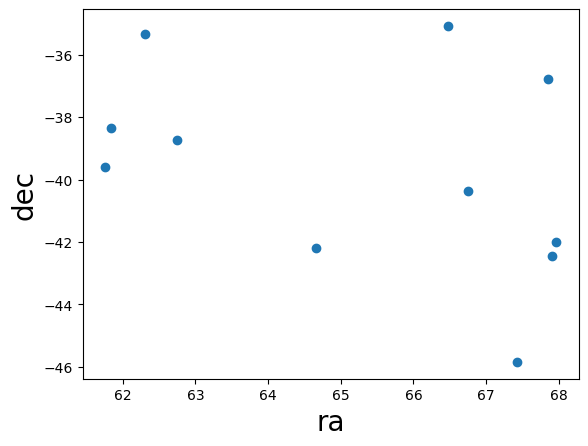

In [8]:
amico_cl = amico_data[amico_data['ID']==7]
plt.scatter(amico_cl['Xphys'], amico_cl['Yphys'])
plt.xlabel('ra', fontsize = 20)
plt.ylabel('dec', fontsize = 20)

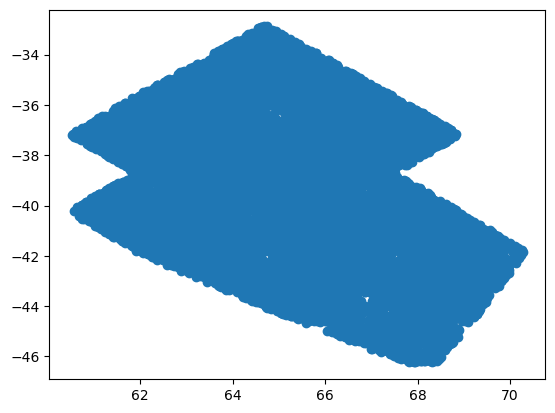

In [9]:
plt.scatter(amico_data['Xphys'], amico_data['Yphys'])

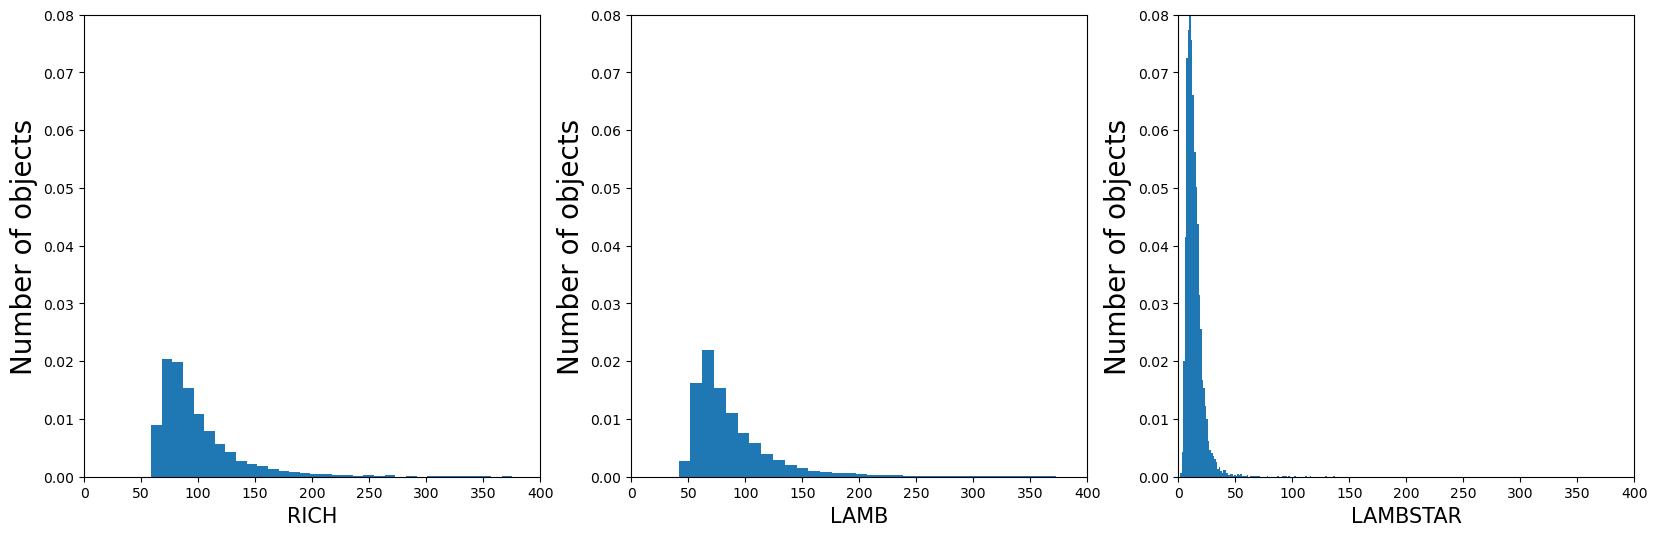

In [10]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (20,6))
def affiche(ax, param):
    ax.hist(amico_data[param], bins = 100, density = True)
    ax.set_xlim([0,400])
    ax.set_ylim([0,.08])
    ax.set_xlabel(param, fontsize = 15)
    ax.set_ylabel('Number of objects', fontsize = 20)
affiche(ax1, 'RICH') # apparent richness based on the filter formalism (visible number of galaxies)
affiche(ax2, 'LAMB') # apparent richness based on the galaxies probability assoc. (visible number of galaxies)
affiche(ax3, 'LAMBSTAR') # apparent richness based on m_star+1.5 (visible number of galaxies)
plt.show()

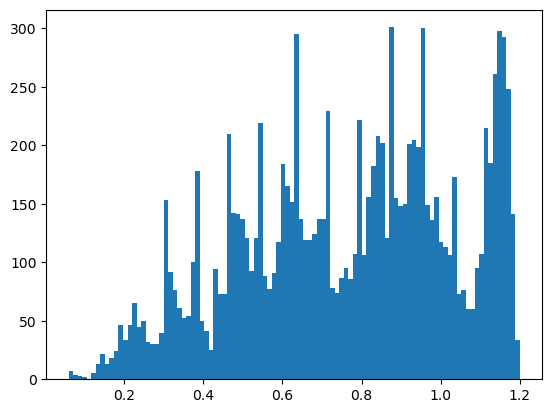

In [11]:
plt.hist(amico_data['Zphys'], bins = 100)
plt.show()

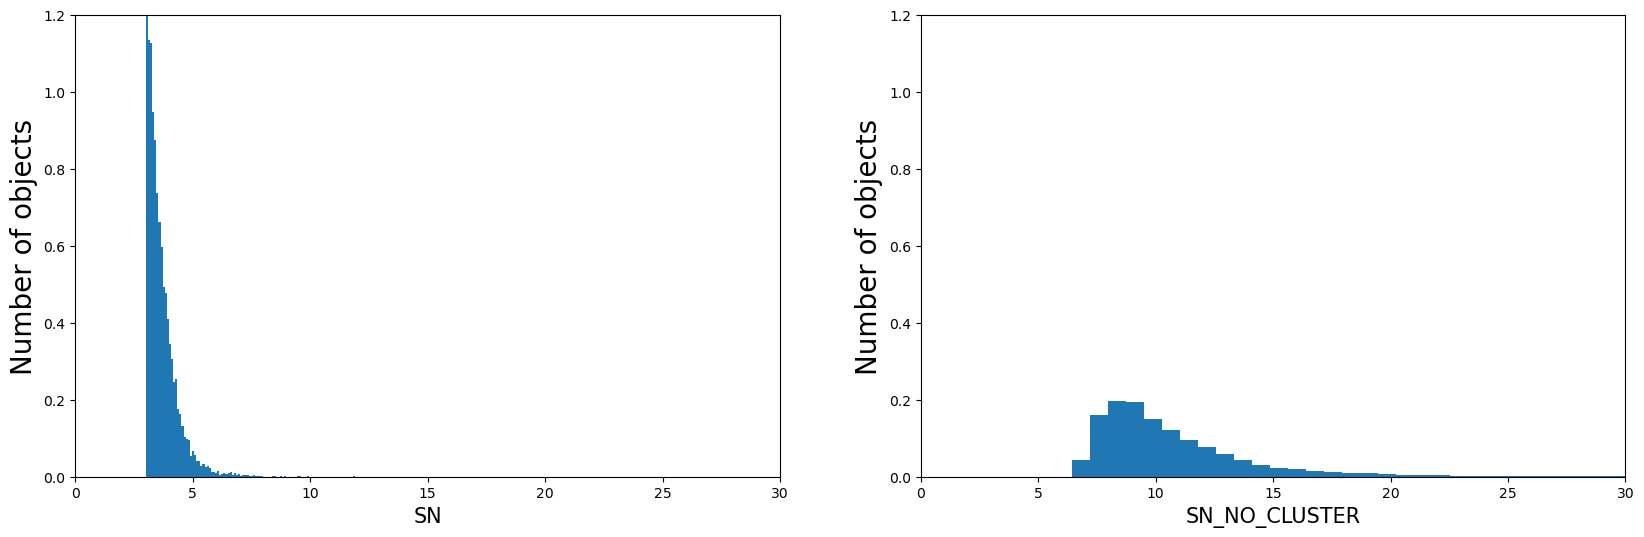

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (20,6))
def affiche(ax, param):
    ax.hist(amico_data[param], bins = 100, density = True)
    ax.set_xlabel(param, fontsize = 15)
    ax.set_ylabel('Number of objects', fontsize = 20)
    ax.set_xlim([0,30])
    ax.set_ylim([0,1.2])
affiche(ax1, 'SN') #signal-to-noise ratio, r.m.s. including background and cluster contributions
affiche(ax2, 'SN_NO_CLUSTER') # signal-to-noise ratio, r.m.s. cluster contribution only
plt.show()

In [25]:
#track evolution of pz
mu_l = []
sig_l = []
pz_l = []
for i in range (119):
    pz_l.append(i)
    mu_l.append(np.mean(amico_data['Pz-{}'.format(i)]))
    sig_l.append(np.std(amico_data['Pz-{}'.format(i)]))
z_l = np.linspace(.015,1.95,119)

Text(0, 0.5, '$\\sigma$')

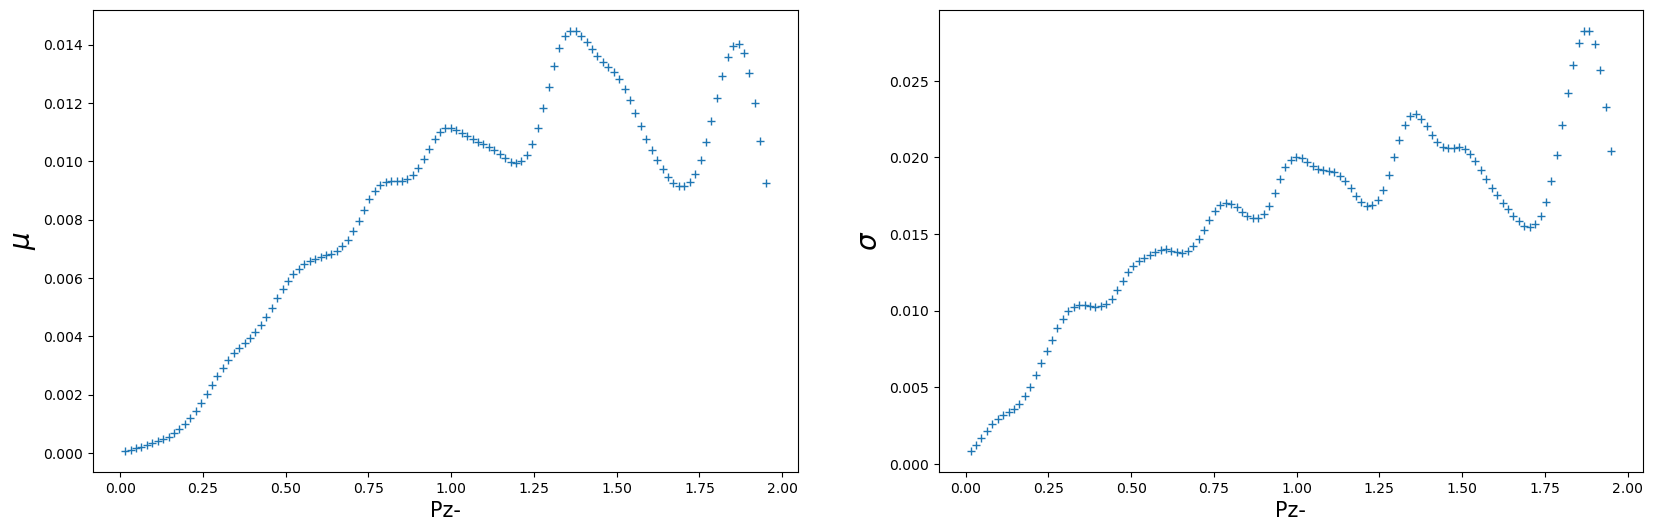

In [27]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (20,6))
ax1.plot(z_l, mu_l, linestyle = 'none', marker = '+')
ax2.plot(z_l, sig_l, linestyle = 'none', marker = '+' )
ax1.set_xlabel('z', fontsize = 15)
ax2.set_xlabel('z', fontsize = 15)
ax1.set_ylabel('$\mu$', fontsize = 20)
ax2.set_ylabel('$\sigma$', fontsize = 20)

(array([4.541e+03, 5.820e+02, 5.950e+02, 5.410e+02, 3.660e+02, 2.630e+02,
        2.260e+02, 1.850e+02, 1.810e+02, 1.590e+02, 1.560e+02, 1.240e+02,
        1.090e+02, 1.240e+02, 9.500e+01, 1.170e+02, 1.060e+02, 1.320e+02,
        1.020e+02, 1.060e+02, 1.020e+02, 8.000e+01, 5.700e+01, 6.200e+01,
        6.500e+01, 5.000e+01, 5.600e+01, 3.700e+01, 5.600e+01, 4.900e+01,
        4.400e+01, 3.300e+01, 4.100e+01, 4.300e+01, 3.700e+01, 3.100e+01,
        3.900e+01, 3.300e+01, 4.100e+01, 3.200e+01, 3.800e+01, 2.100e+01,
        1.900e+01, 2.100e+01, 2.800e+01, 2.900e+01, 3.500e+01, 2.400e+01,
        2.400e+01, 3.000e+01, 2.300e+01, 2.500e+01, 2.500e+01, 2.300e+01,
        2.800e+01, 1.900e+01, 2.300e+01, 1.900e+01, 2.100e+01, 2.900e+01,
        3.000e+01, 3.300e+01, 3.800e+01, 3.300e+01, 2.600e+01, 3.400e+01,
        2.100e+01, 2.600e+01, 2.900e+01, 2.500e+01, 2.700e+01, 4.900e+01,
        4.000e+01, 4.200e+01, 3.900e+01, 1.400e+01, 3.100e+01, 2.100e+01,
        3.800e+01, 3.900e+01, 3.300e+0

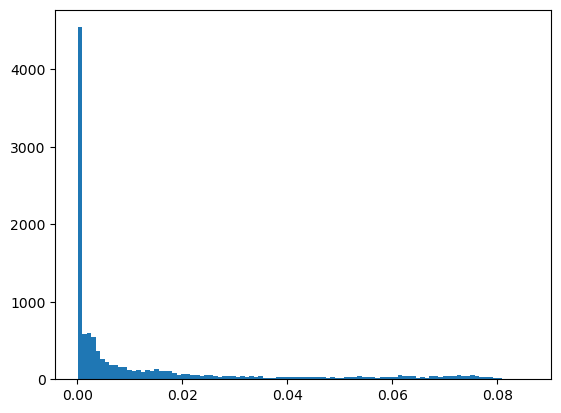

In [30]:
plt.hist(amico_data['Pz-79'], bins = 100)